In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.base           import clone
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score




Here, we investigate which demographic features influence the changes in math test scores in the period 19-23. The goal is to use school level demographic features (which we have previously used successfully to predict SAT/ACT scores) to predict changes in SAT/ACT scores in the periods 2019 - 2020, 2019 - 2021, 2019 -2022, 2019 - 2023. We use the demographic features corresponding to 2019.

Our conclusion is that the same features used to predict test scores in AR and MA earlier are not adequate to predict changes in test scores in these states.

All functions used are defined in the bottom of the notebook, in the 'Auxiliary functions' section.

## Models ##

In [578]:
states = ['AR', 'MA']
years  = [20, 21, 22, 23]
test_type_dict = {'AR': 'ACT', 'MA': 'SAT'}

all_metrics = []
all_models  = []

test_sets = {}

for state in states:
    test_type = test_type_dict[state]
    df = load_data_and_select_cols(state)
    
    for year in years:
        if year == 20 and state == 'AR':
            continue
        # prepare X, y for this (state, year)
        X, y = process_data(df, state, year)
        
        # drop the 2019 score column
        baseline_col = f"{test_type}_math_19"
        if baseline_col in X.columns:
            X = X.drop(baseline_col, axis=1)
        
        # drop other unwanted columns
        for yr2 in years:
            change_col = f"{test_type}_math_change_19_to_{yr2}"
            if change_col in X.columns:
                X = X.drop(change_col, axis = 1)
        
        X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.15)
        # store test data in test_sets
        test_sets[(state, year)] = (X_test,y_test)
        
        # train and evaluate
        metrics, models = train_and_evaluate_models(X_tr, y_tr)
        
        # tag and store
        metrics.update(state = state, year = year)
        models.update(state = state, year = year)
        all_metrics.append(metrics)
        all_models.append(models)


#  all_metrics is a list of dicts with rmse/mae and state/year
#  all_models  is a list of dicts with fitted models and state/year


### Model training loop ###

Here we train our models and plot their average cross validation RMSEs. Our target variables are the score changes 2019-20xy, for xy in {20, 21, 22, 23}.
With the exception of AR, where we do not have 2020 data.

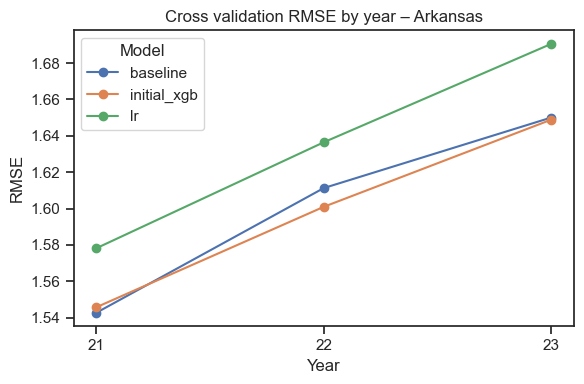

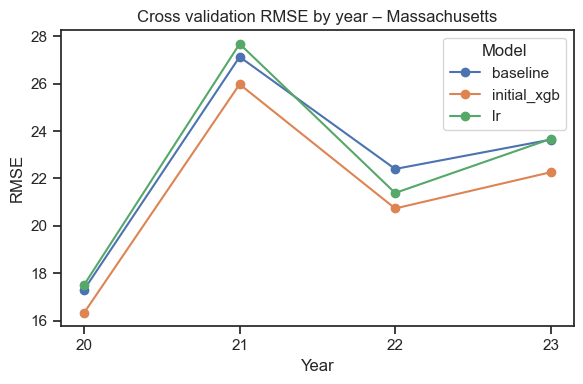

In [536]:
# train and collect metrics
states = ['AR', 'MA']
years  = [20, 21, 22, 23]
test_type = {'AR': 'ACT', 'MA': 'SAT'}

test_sets = {}
training_sets = {}

all_metrics = []    # will hold one dict per (state,year)

for state in states:
    df = load_data_and_select_cols(state)
    tt = test_type[state]
    
    for year in years:
        if year == 20 and state == 'AR':
            continue
        X, y = process_data(df, state, year)
                
        # drop the 2019 baseline and other change cols
        drop_cols = [f"{tt}_math_19"] + [f"{tt}_math_change_19_to_{yr2}" for yr2 in years]
        
        X = X.drop([c for c in drop_cols if c in X.columns], axis=1)

        X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.15)
        # store test data in test_sets
        test_sets[(state, year)] = (X_test,y_test)
        training_sets[(state, year)] = (X_tr, y_tr)
        
        # train and evaluate
        metrics, models = train_and_evaluate_models(X_tr, y_tr)
        
        # tag and store
        metrics.update(state=state, year=year)
        all_metrics.append(metrics)

# plot RMSEs for both states
metrics_df = pd.DataFrame(all_metrics)

# melt into long form for plotting
df_long = metrics_df.melt(id_vars=['state','year'],
                          value_vars=['rmse_baseline','rmse_lr','rmse_initial_xgb'],
                          var_name='model',
                          value_name='rmse')
                         
# clean up model names
df_long['model'] = df_long['model'].str.replace('rmse_','', regex = False)

# loop through each state and plot
for state in states:
    if state == 'AR':
        state_name = 'Arkansas'
    elif state == 'MA':
        state_name = 'Massachusetts'
    else:
        raise NotImplementedError()
    sub = df_long[df_long['state'] == state]
    pivot = sub.pivot(index = 'year', columns = 'model', values = 'rmse')
    
    ax = pivot.plot(marker = 'o', figsize = (6,4), title = f"Cross validation RMSE by year – {state_name}")
    ax.set_xticks(pivot.index)
    ax.set_xlabel('Year')
    ax.set_ylabel('RMSE')
    ax.legend(title = 'Model')
    
    plt.tight_layout()
    plt.savefig(f"rmse_plot_{state}_score_change.png", dpi = 300, bbox_inches = 'tight')
    plt.show()


We see that the cross validation RMSE is comparable to the one of the baseline model: not a good sign. Now we will evaluate these models in different ways.

## Model evaluation ##

We evaluate our models above using permutation importance and other metrics.

### Permutation importance ###

We look at permutation importance for the 2021 models, as an example.

In [540]:
model_AR21_lr = all_models[0]['lr_pipe']
model_AR21_xgb = all_models[0]['initial_xgb']
X_tr_AR21, y_tr_AR21 = training_sets[('AR', 21)]

model_MA21_lr = all_models[4]['lr_pipe']
model_MA21_xgb = all_models[4]['initial_xgb']
X_tr_MA21, y_tr_MA21 = training_sets[('MA', 21)]

First we look at the Massachusetts models:

In [541]:
perm_MA21_lr = permutation_importance(model_MA21_lr, X_tr_MA21, y_tr_MA21, scoring = 'neg_root_mean_squared_error', n_repeats = 30)
importance_MA21_lr = pd.Series(perm_MA21_lr.importances_mean, index = X_tr_MA21.columns)
print('Permutation importance in MA21 linear regression model:')
importance_MA21_lr

Permutation importance in MA21 linear regression model:


tests_taken                  0.019297
avg_class_size               0.211236
number_of_students           0.255539
perc_english_learner         1.306198
perc_disabilities            2.604355
perc_econ_disadvg            1.394764
perc_african_american        0.905307
perc_asian                   0.641828
perc_hispanic                0.781121
perc_native_american         0.147274
perc_hawaiian_pacific_isl    0.055744
perc_multi_race_non_hisp     0.790233
total_exp_per_pupil          0.856219
dtype: float64

In [542]:
perm_MA21_xgb = permutation_importance(model_MA21_xgb, X_tr_MA21, y_tr_MA21, scoring = 'neg_root_mean_squared_error', n_repeats = 30)
importance_MA21_xgb = pd.Series(perm_MA21_xgb.importances_mean, index = X_tr_MA21.columns)
print('Permutation importance in MA21 XGBoost model:')
importance_MA21_xgb

Permutation importance in MA21 XGBoost model:


tests_taken                  2.200787
avg_class_size               3.423133
number_of_students           3.524178
perc_english_learner         2.077902
perc_disabilities            2.590835
perc_econ_disadvg            4.450584
perc_african_american        4.026289
perc_asian                   6.763262
perc_hispanic                3.403978
perc_native_american         0.777524
perc_hawaiian_pacific_isl    0.458528
perc_multi_race_non_hisp     2.873871
total_exp_per_pupil          2.959691
dtype: float64

We can see that the permutation importance of all features in both models is quite low (remember that in MA, the exam used is the SAT, which for its math has a scale 0-800). Recall that the permutation importance (as per the scikit-learn documentation) "is defined to be the decrease in a model score when a single feature value is randomly shuffled." Since the RMSE (our scoring function) is in the same units as our target variable, a change in model score of around 5 points when shuffling feature values is quite low. But, we can also see that this tends to be higher for the XGBoost model, which agrees with the fact that it seems to perform better. 

We also have to keep in mind that we are finding the permutation importance with the training data: in general this is over-optimistic. So a low permutation importance on the training data is a signal that our models aren't really using the features in a significant way.

Now we do the same for the AR21 models:

In [546]:
perm_AR21_lr = permutation_importance(model_AR21_lr, X_tr_AR21, y_tr_AR21, scoring = 'neg_root_mean_squared_error', n_repeats = 30)
importance_AR21_lr = pd.Series(perm_AR21_lr.importances_mean, index = X_tr_AR21.columns)
print('Permutation importance in AR21 linear regression model:')
importance_AR21_lr

Permutation importance in AR21 linear regression model:


perc_test_taking_grades_9_12_students    0.007333
number_of_students                      -0.000692
perc_frl                                 0.013626
perc_hispanic                           -0.000159
perc_african_american                    0.009385
perc_other_race                          0.003338
is_open_enrollment_charter               0.004713
dtype: float64

In [545]:
perm_AR21_xgb = permutation_importance(model_AR21_xgb, X_tr_AR21, y_tr_AR21, scoring = 'neg_root_mean_squared_error', n_repeats = 30)
importance_AR21_xgb = pd.Series(perm_AR21_xgb.importances_mean, index = X_tr_AR21.columns)
print('Permutation importance in AR21 XGBoost model:')
importance_AR21_xgb

Permutation importance in AR21 XGBoost model:


perc_test_taking_grades_9_12_students    0.039265
number_of_students                       0.068485
perc_frl                                 0.072666
perc_hispanic                            0.026069
perc_african_american                    0.039138
perc_other_race                          0.052300
is_open_enrollment_charter               0.000000
dtype: float64

We observe the same as in the MA21 models above, even taking to account the different scale of ACT exams.

### Cross validation R² ###

We again use as examples the AR21 and MA21 models evaluated above.

In [560]:
cv_scores = cross_val_score(model_AR21_lr, X_tr_AR21, y_tr_AR21, scoring = 'r2', cv = 5)
cv_r2_initial_xgb = cross_val_score(model_AR21_xgb, X_tr_AR21, y_tr_AR21, scoring = 'r2', cv = 5)

print("Cross validation R² for AR 2021 (XGBoost model):", cv_r2_initial_xgb.mean())
print('Cross-validation R² for AR 2021 (Linear regression model):', cv_scores.mean())

Cross validation R² for AR 2021 (XGBoost model): -0.2998650431772742
Cross-validation R² for AR 2021 (Linear regression model): -0.05744958292045048


In [561]:
cv_scores = cross_val_score(model_MA21_lr, X_tr_MA21, y_tr_MA21, scoring = 'r2', cv = 5)
cv_r2_initial_xgb = cross_val_score(model_MA21_xgb, X_tr_MA21, y_tr_MA21, scoring = 'r2', cv = 5)

print("Cross validation R² for MA 2021 (XGBoost model):", cv_r2_initial_xgb.mean())
print('Cross-validation R² for MA 2021 (Linear regression model):', cv_scores.mean())

Cross validation R² for MA 2021 (XGBoost model): -0.1032201130412207
Cross-validation R² for MA 2021 (Linear regression model): 0.007128266068056277


We can see that the cross-validation R² scores are negative in three out of four models, meaning that we are better off using the baseline model than these models! And we have computed this using the data on which these were trained: we expect them to do even worse on unseen data. In the only case where it is nonnegative, it is very small, so it very well might be a matter of randomness.

We look now at the predictions of our linear models on the training set (the ones corresponding to the XGBoost models can be easily obtained in the same way; they do not look much better).

Text(0, 0.5, 'Predicted')

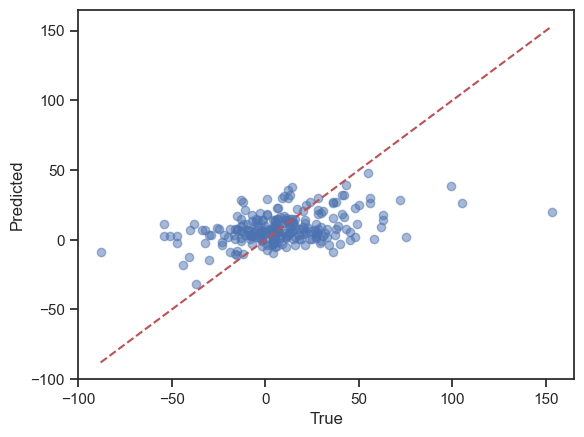

In [564]:
y = y_tr_MA21
plt.scatter(y, model_MA21_lr.predict(X_tr_MA21), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")

Text(0, 0.5, 'Predicted')

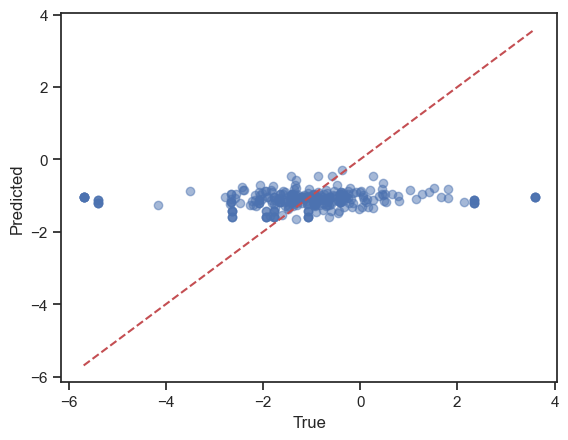

In [565]:

y = y_tr_AR21
plt.scatter(y, model_AR21_lr.predict(X_tr_AR21), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")

We can see that the models in fact almost predict the baseline values.

### Features/target scatterplot ###

The following helps us visualize the relationship between demographic features and score changes. Currently set to MA, but can be used for AR by choosing the appropriate feature names.

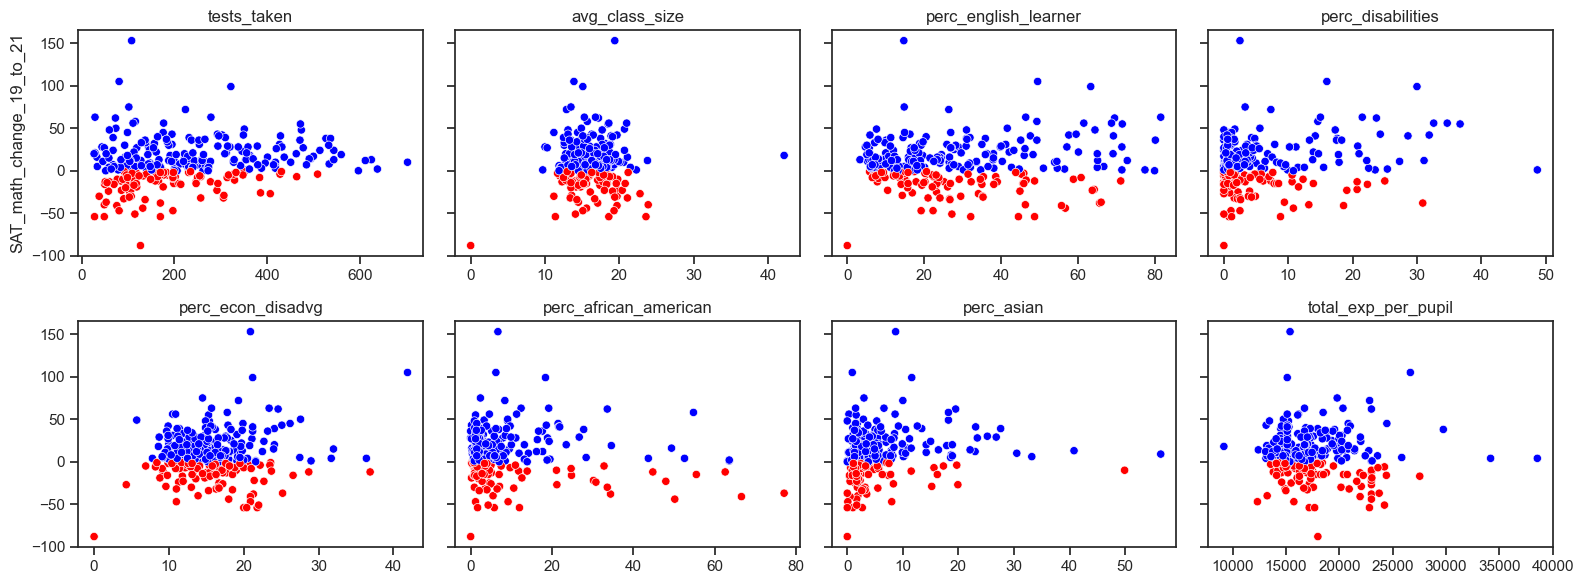

In [555]:
state = 'MA'
df = load_data_and_select_cols(state)

features = [
    'tests_taken', 'avg_class_size', 
    'perc_english_learner', 'perc_disabilities', 'perc_econ_disadvg',
    'perc_african_american', 'perc_asian', 
 'total_exp_per_pupil'
]
target = 'SAT_math_change_19_to_21'

# add a flag for negative change
df['neg'] = df[target] < 0

cols = 4
rows = math.ceil(len(features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, features):
    sns.scatterplot(
        x=feat,
        y=target,
        data=df,
        hue='neg',
        palette={True: 'red', False: 'blue'},
        legend=False,
        ax=ax
    )
    ax.set_title(feat)
    ax.set_ylabel(target if ax is axes[0] else "")
    ax.set_xlabel("")  

# any empty subplots
for ax in axes[len(features):]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig(f"rmse_plot_{state}_score_change_scatterplot.png", dpi=300, bbox_inches='tight')
plt.show()



## Evaluating performance on the test sets ##

In [585]:
all_test_metrics = []

for rec in all_models:
    state, year = rec['state'], rec['year']
    
    # get the corresponding test set
    X_test, y_test = test_sets[(state, year)]

    # evaluate all models on this test set
    metrics = evaluate_models_on_test_set(rec, X_test, y_test)

    # attach state and year for identification
    metrics.update(state=state, year=year)

    all_test_metrics.append(metrics)


In [ ]:
df_res = pd.DataFrame(all_test_metrics)

df_long = df_res.melt(id_vars = ['year', 'state'],
                      value_vars = ['rmse_baseline', 'rmse_lr', 'rmse_initial_xgb'],
                      var_name = 'model',
                      value_name = 'rmse')

df_long['model'] = df_long['model'].str.replace('rmse_', '')

# plot the RMSEs for the different models in the same plot, for each state
for state in df_long['state'].unique():
    sub = df_long[df_long['state'] == state]
    pivot = sub.pivot(index = 'year', columns = 'model', values = 'rmse')

    ax = pivot.plot(marker = 'o',
                    title=f"Test RMSE for each model and year, for {state}",
                    figsize=(8, 5))
    ax.set_xlabel('Year')
    ax.set_ylabel('RMSE')
    ax.legend(title = 'Model')
    plt.tight_layout()
    plt.savefig(f"rmse_test_set_plot_{state}.png", dpi=300, bbox_inches='tight')
    
    plt.show()

We can see that, as we predicted, the models do not do a good job on the test set.

## Conclusion ##

Unlike for the case of predicting exam scores, in this case neither linear nor non-linear models trained successfully predict score changes. It is very well possible that the features used are not adequate for this task, unlike what we expected when starting this project.

# Auxiliary functions #

#### Loading data and selecting columns ####

In [512]:
def load_data_and_select_cols(state):
    """
    Load a state’s comparison CSV, drop irrelevant/collinear columns, 
    and add TEST_math_change_19_to_YEAR features for years 2020–2023.

    Args:
        state (str): Two‐letter code 'AR' or 'ACT'

    Returns:
        pandas.DataFrame: Preprocessed data with only modeling features and new <test_name>_math_change_19_to_<year> columns.
    """

    folder = os.path.join(r'C:\Users\mauro\OneDrive\Desktop\MATH\Spring_2025\Erdos\project\project_files\data', state + '_comparison')
    filename = state + '_comparison.csv' 
    filepath = os.path.join(folder, filename)
    df = pd.read_csv(filepath)

    test_type_dict = {'AR':'ACT', 'MA' : 'SAT'}
    test_type = test_type_dict[state]
    
    drop_cols = []
    
    if state == 'AR':
        # we drop columns which directly relate to test results: it is very likely that, e.g. science ACT results correlate highly with math ACT results.
        other_test_results = ['perc_math_readiness',
                                'perc_english_readiness', 'perc_reading_readiness',
                                'perc_science_readiness', 'perc_all_subject_readiness',
                                'ACT_english', 'ACT_reading', 'ACT_science',' Average % ACT Composite Score ',
                             'Average ACT Composite Score']
        # now we drop other features that we will not use.
        irrelevant_features = ['school_name', 'Grades', 'Grade', 'District Name','Region', 'County', 'School LEA', 
                               'DLEA', 'year',' Number of Students in Grades 9-12 ', 'Year',
                               ' % Students in grade 9-12 that took the ACT2', '% of Exams that scored 3 or Above',
                               'number_AP_exam_taking_students', 'number_AP_exams_taken'
                              ]
        other_drop = ['perc_white', 'perc_minority', test_type + '_math']
        
        drop_cols += other_test_results + irrelevant_features + other_drop
        drop_cols = [col for col in drop_cols if col in list(df.columns)]
        
    elif state == 'MA':
        other_test_results = ['SAT_reading_writing']
        irrelevant_features = ['school_name', 'School Code', 'Total # of Classes', 'Female %', 'Male %','District Code',
                               'District Name', 'In-District Expenditures','Total In-district FTEs', 'In-District Expenditures per Pupil',
                               'Total Expenditures', 'Total Pupil FTEs', 'year'
                              ]
        # cannot have all the % ethnicities as features, since they would always sum to 100
        other_drop = ['perc_white']
        drop_cols += irrelevant_features + other_test_results + other_drop
        
        drop_cols = [col for col in drop_cols if col in list(df.columns)]
        
    elif state == 'IL':
        raise NotImplementedError()

    for year in range(20,24):
        if year == 20 and state == 'AR':
            continue
        df[test_type + '_math_change_19_to_' + str(year)] = df[test_type + '_math_' + str(year)] - df[test_type + '_math_' + '19']

    for year in range(20,24):
        if test_type + '_math_' + str(year) in list(df.columns):
            drop_cols.append(test_type + '_math_' + str(year))
    
    df = df.drop(drop_cols, axis = 1)
    

    return df

### Training models ###

In [513]:
def train_and_evaluate_models(X, y, n_splits=5, random_state = 11):
    """
    Performs k‑fold cross‑validation for a baseline predictor, linear regression (with averaged CV coefficients), 
    and XGBoost; then fits final models on all data.

    Args:
        X (array‐like or DataFrame): Training feature matrix.
        y (array‐like or Series): Training vector.
        n_splits (int): Number of CV folds.
        random_state (int): Seed for reproducibility.

    Returns:
        metrics (dict): Mean RMSE/MAE for baseline, LR, and XGBoost.
        models  (dict): 
            - 'lr_cv_avg_coef': averaged LR coefficients from CV,
            - 'lr_pipe' & 'lr': fitted scaler+LR pipeline and its regressor,
            - 'initial_xgb': final XGBoost model on all data.
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    metrics, models = {}, {}

    # ------------------baseline model
    rmse_baseline = []
    mae_baseline = []
    for tr_idx, val_idx in kf.split(X):
        y_tr, y_val = (y.iloc[tr_idx], y.iloc[val_idx]) if hasattr(y, "iloc") \
                      else (y[tr_idx],    y[val_idx])
        y_hat = np.full_like(y_val, np.mean(y_tr))
        rmse_baseline.append(np.sqrt(mean_squared_error(y_val, y_hat)))
        mae_baseline.append(np.abs(mean_absolute_error(y_val, y_hat)))
        
    metrics["rmse_baseline"] = np.mean(rmse_baseline)
    metrics["mae_baseline"] = np.mean(mae_baseline)

    # ---------------- linear regression

    lr_pipe = make_pipeline(StandardScaler(), LinearRegression())
    rmse_lr = []
    # here we will store the coefficients for the model trained on each cross validation step
    fold_coefs_raw = []
    
    for tr_idx, val_idx in kf.split(X):
        # for when we use a pandas dataframe
        if hasattr(X, "iloc"):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        # for when we use a numpy array
        else:
            X_tr, X_val = X[tr_idx], X[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]

        model = clone(lr_pipe).fit(X_tr, y_tr)
        rmse_lr.append(np.sqrt(mean_squared_error(y_val, model.predict(X_val))))

        scaler = model.named_steps['standardscaler']
        # need to undo standardization so that coefficients of the different models can be averaged without getting nonsense
        beta = model.named_steps['linearregression'].coef_ / scaler.scale_
        fold_coefs_raw.append(beta)
        
    metrics["rmse_lr"] = np.mean(rmse_lr)
    
    # compute and store the average coefficients
    avg_coef = np.mean(fold_coefs_raw, axis = 0)
    models["lr_cv_avg_coef"] = avg_coef 
    
    lr_pipe.fit(X, y)
    models["lr"] = lr_pipe.named_steps["linearregression"]
    # also store the pipeline for when we evaluate on the test set at the end (since we have used StandardScaler, which scales using training data stats)
    models['lr_pipe'] = lr_pipe

    # -------------------------- XGBoost 
    xgb_params = {'learning_rate':0.1, 'max_depth':3, 'n_estimators':100,
        'subsample' : 0.6, 'early_stopping_rounds' : 10, 'objective' : "reg:squarederror", 'verbosity' : 0}

    xgb_template = xgb.XGBRegressor(**xgb_params)

    rmse_xgb = []
    mae_xgb = []
    
    for tr_idx, val_idx in kf.split(X):
        if hasattr(X, "iloc"):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        else:
            X_tr, X_val = X[tr_idx],    X[val_idx]
            y_tr, y_val = y[tr_idx],    y[val_idx]

        model = clone(xgb_template).fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        rmse_xgb.append(np.sqrt(mean_squared_error(y_val, model.predict(X_val))))
        mae_xgb.append(mean_absolute_error(y_val, model.predict(X_val)))
        
    metrics["rmse_initial_xgb"] = np.mean(rmse_xgb)
    metrics["mae_initial_xgb"] = np.mean(mae_xgb)

    models["initial_xgb"] = (clone(xgb_template).set_params(early_stopping_rounds=None).fit(X, y))


    return metrics, models


### Test set evaluation ###

In [571]:
def evaluate_models_on_test_set(models, X_test, y_test):
    metrics = {}

    # baseline
    y_pred_baseline = np.full_like(y_test, np.mean(y_test), dtype=np.float64)
    metrics["rmse_baseline"] = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
    # metrics["mae_baseline"]  = mean_absolute_error(y_test, y_pred_baseline)

    # linear regression pipeline
    if "lr_pipe" in models:
        y_pred_lr = models["lr_pipe"].predict(X_test)
        metrics["rmse_lr"] = np.sqrt(mean_squared_error(y_test, y_pred_lr))
        # metrics["mae_lr"]  = mean_absolute_error(y_test, y_pred_lr)

    # initial xgb
    if "initial_xgb" in models:
        y_pred_initial_xgb = models["initial_xgb"].predict(X_test)
        metrics["rmse_initial_xgb"] = np.sqrt(mean_squared_error(y_test, y_pred_initial_xgb))
        # metrics["mae_initial_xgb"]  = mean_absolute_error(y_test, y_pred_initial_xgb)

    # tuned xgb (grid search)
    if "grid_xgb" in models:
        y_pred_grid_xgb = models["grid_xgb"].predict(X_test)
        metrics["rmse_grid_xgb"] = np.sqrt(mean_squared_error(y_test, y_pred_grid_xgb))
        # metrics["mae_grid_xgb"]  = mean_absolute_error(y_test, y_pred_grid_xgb)

    return metrics


### Visualizing metrics ###

In [550]:
def plot_cv_rmse_mae(metrics):
    """
    visualizes the average cross validation RMSE stored in the metrics dict returned by
    train_and_evaluate_models.
    """
    rmse = (pd.Series(metrics).filter(like = 'rmse').rename(index = {'rmse_baseline'     : 'Baseline',
                                                                'rmse_lr'           : 'Linear regression',
                                                                'rmse_initial_xgb'  : 'XGBoost'
                                                               }).sort_values())    
    mae = (pd.Series(metrics).filter(like = 'mae').rename(index = {'mae_baseline'     : 'Baseline', 
                                                               'mae_lr'           : 'Linear regression',
                                                               'mae_initial_xgb'  : 'XGBoost'
                                                                  }).sort_values())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

    # plot RMSE
    sns.barplot(ax = axes[0], x = rmse.values, y = rmse.index, orient = 'h')
    axes[0].set_xlabel('Average cross validation RMSE')
    axes[0].set_ylabel('')
    axes[0].set_title('RMSE')
    for i, v in enumerate(rmse.values):
        axes[0].text(v, i, f'{v:0.2f}', va = 'center', ha = 'left', fontsize = 9)

    # plot MAE
    sns.barplot(ax = axes[1], x = mae.values, y = mae.index, orient = 'h')
    axes[1].set_xlabel('Average cross validation MAE')
    axes[1].set_ylabel('')
    axes[1].set_title('MAE')
    for i, v in enumerate(mae.values):
        axes[1].text(v, i, f'{v:0.2f}', va = 'center', ha = 'left', fontsize = 9)

    # set title and fix format
    fig.suptitle('Model comparison (cross validation)', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top = 0.85, wspace = 0.4)  
    plt.show()



### Processing data ###

In [421]:
def process_data(df, state, target_year):
    test_type_dict = {'AR': 'ACT', 'MA':'SAT', 'IL': 'SAT'}
    test_type = test_type_dict[state]
        
    y = df[test_type + "_math_change_19_to_" + str(target_year)]
    
    X = df.drop(test_type + "_math_change_19_to_" + str(target_year), axis = 1)

    return X, y
